# Object Recognition in Images

In [1]:
import keras
from tensorflow import keras
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

%matplotlib inline

## Introduction

CIFAR-10 is a popular computer-vision dataset commonly used for object recognition. The actual dataset contains 80 million tiny images howeer we will be using a subset of 60,000 images to make predictions. The smaller CIFAR-10 data consists of 60,000 32x32 color images in 10 classess, with 6000 images per class. There are 50,000 training images and 10,000 test images.

The label classes in the dataset are:
- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- horse
- ship
- truck

With the dataset provided, we will use a deep Convolutional Neural Network (CNN) to tackle this multiclass classification problem.

In [2]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


## Exploratory Data Analysis

As you can see we have a perfectly balanced dataset. This ensures that the model won't be biased toward any particular class, allowing for fair training and more accurate predictions across all categories.

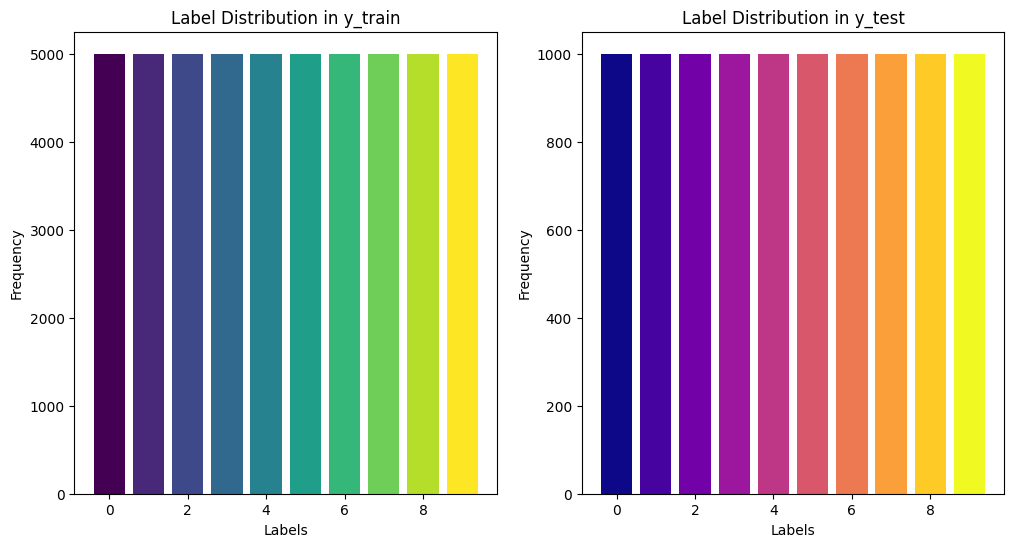

In [ ]:

train_unique, train_counts = np.unique(y_train, return_counts=True)
test_unique, test_counts = np.unique(y_test, return_counts=True)

# Create a subplot with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

train_colors = plt.cm.viridis(np.linspace(0, 1, len(train_unique)))
test_colors = plt.cm.plasma(np.linspace(0, 1, len(test_unique)))

# Plot the distribution for y_train
axes[0].bar(train_unique, train_counts, color=train_colors)
axes[0].set_xlabel('Labels')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Label Distribution in y_train')

# Plot the distribution for y_test
axes[1].bar(test_unique, test_counts, color=test_colors)
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Label Distribution in y_test')

plt.show()


The training images are colored, but they seem to be of low quality and somewhat blurry. Additionally, the objects in the images are captured from various angles and rotations, with some images not fully displaying the object. Therefore, data preprocessing will be necessary before building the model to ensure a more robust performance and generalize the data better for real life predictions.

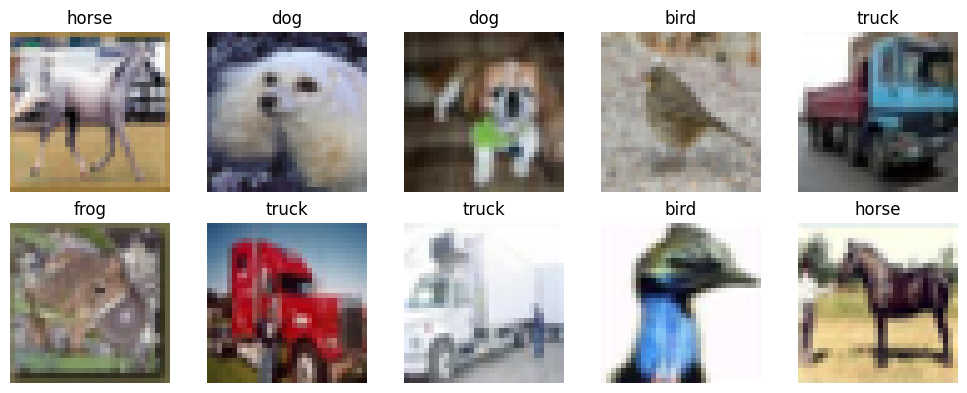

In [ ]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

random_indices = np.random.randint(0, x_train.shape[0], 10)

# Set up the subplot grid (2 rows, 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()

# Loop through the random indices and plot the images with their corresponding labels
for i, index in enumerate(random_indices):
    # Get the image
    axes[i].imshow(x_train[index])
    axes[i].axis('off')

    label = y_train[index][0]
    # Set the title to the corresponding label
    axes[i].set_title(label_names[label])

# Adjust spacing between subplots
plt.tight_layout()
plt.show()


Let's perform one-hot encoding on the labels. For example, if the label is "airplane," it will be represented as [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], where each position corresponds to a specific class, and a '1' indicates the presence of that class while all other positions are '0'. This will make them suitable for CNN models by outputing the probabilities for each class.

In [3]:
# Normalize the data. Before we need to connvert data type to float for computation.
batch_size = 32  # The default batch size of keras.
num_classes = 10

#x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')
#x_train /= 255
#x_test /= 255

# Convert class vectors to binary class matrices. This is called one hot encoding.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

We will preprocess the image data using ImageDataGenerator. The train_gen and test_gen will randomly rotate the images by up to 10 degrees and normalize the pixel values by scaling them to a range of [0, 1] (by dividing by 255). This will help improve the model’s robustness and generalization, reducing the risk of overfitting.

In [4]:
IMAGE_SIZE = 32
num_train_samples = len(x_train)
train_batch_size = 64
val_batch_size = 64

train_steps = np.ceil(num_train_samples / train_batch_size)

datagen = ImageDataGenerator(rotation_range=10,
                            horizontal_flip=True,
                            rescale=1./255)

train_gen = datagen.flow(x_train, y_train, batch_size=train_batch_size,)

test_gen = datagen.flow(x_test,y_test, batch_size=val_batch_size)


In [5]:
x_train[1:].shape

(49999, 32, 32, 3)

## Model Architecture

CNNs are well-suited for object recognition because they effectively capture patterns in images using small filters that focus on local regions. Since images often contain thousands of parameters, CNNs help reduce this complexity, minimizing overfitting. Additionally, incorporating max-pooling layers enables the model to recognize objects regardless of their position within the image.

We will be constructing CNN models with different numbers of layers. There will be three variations: one with 2 Conv2D layers, another with 4 Conv2D layers, and a third with 6 Conv2D layers. After every two Conv2D layers, max-pooling will be applied. The model will then have three dense layers followed by an output layer.

The following models will use the ReLU activation for Convulation layers to incorporate non-linearity and softmax activation function for the output layer as we have a multiclass classification problem.

### Model with 2 convolutional layers

In [ ]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


simple_model = Sequential()
simple_model.add(Conv2D(first_filters, kernel_size, padding='same', activation = 'relu', input_shape = x_train.shape[1:]))
simple_model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
simple_model.add(MaxPooling2D(pool_size = pool_size))

simple_model.add(Flatten())
simple_model.add(Dense(512, activation = "relu"))
simple_model.add(Dense(256, activation = "relu"))
simple_model.add(Dense(64, activation = "relu"))
simple_model.add(Dense(num_classes, activation = "softmax"))

simple_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 7200)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,686,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,845,482 (14.67 MB)

 Trainable params: 3,845,482 (14.67 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.0001, name='ADAM')
sgd = SGD(learning_rate=0.001, momentum=0.9)

simple_model.compile(sgd, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
simple_model.fit(train_gen,validation_data=(x_test/255,y_test), epochs=10)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.6379 - loss: 1.0283 - val_accuracy: 0.6310 - val_loss: 1.0492
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.6515 - loss: 0.9843 - val_accuracy: 0.6298 - val_loss: 1.0380
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.6666 - loss: 0.9384 - val_accuracy: 0.6488 - val_loss: 0.9987
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.6790 - loss: 0.9146 - val_accuracy: 0.6522 - val_loss: 0.9941
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.6893 - loss: 0.8754 - val_accuracy: 0.6560 - val_loss: 0.9802
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.7063 - loss: 0.8388 - val_accuracy: 0.6674 - val_loss: 0.9446
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.7153 - loss: 0.8100 - val_accuracy: 0.6620 - val_loss: 0.9755
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.7216 - loss: 0.7883 - 

### Model with 4 convolutional layers

In [ ]:
kernel_size = (3,3)
pool_size = (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

# Rename simple_model to model2
model2 = Sequential()

# Add layers to model2
model2.add(Conv2D(first_filters, kernel_size, padding='same', activation = 'relu', input_shape = x_train.shape[1:]))
model2.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model2.add(MaxPooling2D(pool_size = pool_size))

model2.add(Conv2D(second_filters, kernel_size, padding='same', activation = 'relu'))
model2.add(Conv2D(second_filters, kernel_size, activation = 'relu'))
model2.add(MaxPooling2D(pool_size = pool_size))

model2.add(Flatten())
model2.add(Dense(512, activation = "relu"))
model2.add(Dense(256, activation = "relu", kernel_regularizer=l2(0.01)))
model2.add(Dense(64, activation = "relu"))
model2.add(Dense(num_classes, activation = "softmax"))

model2.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 30, 30, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 15, 15, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 512)                 │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,394,154 (5.32 MB)

 Trainable params: 1,394,154 (5.32 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.0001, name='ADAM')
sgd = SGD(learning_rate=0.001)

model2.compile(adam, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model2.fit(train_gen,validation_data=(x_test/255, y_test), epochs=10)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 40ms/step - accuracy: 0.7456 - loss: 0.7960 - val_accuracy: 0.6870 - val_loss: 1.0061
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.7611 - loss: 0.7451 - val_accuracy: 0.6840 - val_loss: 1.0078
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.7700 - loss: 0.7205 - val_accuracy: 0.6923 - val_loss: 0.9916
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.7816 - loss: 0.6927 - val_accuracy: 0.6948 - val_loss: 0.9991
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.7909 - loss: 0.6616 - val_accuracy: 0.6968 - val_loss: 0.9958
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.8019 - loss: 0.6361 - val_accuracy: 0.7047 - val_loss: 0.9754
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.8106 - loss: 0.6125 - val_accuracy: 0.6977 - val_loss: 1.0150
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.8235 - loss: 0.5819 - 

### Model with 6 convolutional layers

In [ ]:
kernel_size = (3, 3)
pool_size = (2, 2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

# Rename simple_model to model3
model3 = Sequential()

# Add layers to model3
model3.add(Conv2D(first_filters, kernel_size, padding='same', activation='relu', input_shape=x_train.shape[1:]))
model3.add(Conv2D(first_filters, kernel_size, activation='relu'))
model3.add(MaxPooling2D(pool_size=pool_size))

model3.add(Conv2D(second_filters, kernel_size, padding='same', activation='relu'))
model3.add(Conv2D(second_filters, kernel_size, activation='relu'))
model3.add(MaxPooling2D(pool_size=pool_size))
model3.add(Dropout(dropout_conv))

model3.add(Conv2D(second_filters, kernel_size, padding='same', activation='relu'))
model3.add(Conv2D(second_filters, kernel_size, activation='relu'))
model3.add(MaxPooling2D(pool_size=pool_size))
model3.add(Dropout(dropout_conv))

model3.add(Flatten())
model3.add(Dense(512, activation="relu"))
model3.add(Dense(256, activation="relu", kernel_regularizer=l2(0.01)))
model3.add(Dense(64, activation="relu"))
model3.add(Dense(num_classes, activation="softmax"))

model3.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 30, 30, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 15, 15, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 6, 6, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 419,434 (1.60 MB)

 Trainable params: 419,434 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.0001, name='ADAM')
sgd = SGD(learning_rate=0.001, momentum=0.9)

model3.compile(adam, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model3.fit(train_gen,validation_data=(x_test/255, y_test), epochs=10)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 38s 41ms/step - accuracy: 0.1760 - loss: 4.2465 - val_accuracy: 0.3747 - val_loss: 2.1972
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.3721 - loss: 2.0969 - val_accuracy: 0.4447 - val_loss: 1.7491
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.4231 - loss: 1.7713 - val_accuracy: 0.4720 - val_loss: 1.5815
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.4512 - loss: 1.6198 - val_accuracy: 0.4935 - val_loss: 1.4751
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.4704 - loss: 1.5287 - val_accuracy: 0.5166 - val_loss: 1.3904
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.4922 - loss: 1.4666 - val_accuracy: 0.5414 - val_loss: 1.3176
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.5160 - loss: 1.3881 - val_accuracy: 0.5460 - val_loss: 1.3141
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.5289 - loss: 1.3507 - 

## Analysis and Hyperparameter Tuning

We developed three different models, each with a varying number of convolutional layers. Among these, the model with 4 convolutional layers yielded the highest accuracy, achieving a training accuracy of 0.8364 and a validation accuracy of 0.6966. One of the other models with 2 layers of Conv2D achieved a training accuracy of 0.7444 and a validation accuracy of 0.6831, while the third model with 6 layers had a training accuracy of 0.5557 and a validation accuracy of 0.5785. While the 4 Conv2d layer model performs well, there is still room for improvement. Therefore, we will proceed with this model to fine-tune the hyperparameters and potentially adjust the architecture for further optimization.

The model with 4 convolutional layers demonstrated a consistent improvement in accuracy and a steady decrease in loss after each epoch, indicating that it is effectively learning from the data and making progress during training. This steady learning trend suggests that the model is successfully capturing patterns and generalizing well but maybe overfitting the data as the training accuracy is higher than the validation accuracy.

### Model with 4 Convolutional layers

In the previous iteration of this model, as discussed in the 'Model Architecture' section, we achieved a training accuracy of 0.8364 and a validation accuracy of 0.6966. The significant gap between the training and validation accuracy indicates that the model is overfitting to the training data. To address this, we can apply regularization techniques such as L2 regularization or dropout to help the model generalize better on the test data.

In [6]:
kernel_size = (3,3)
pool_size = (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

# Rename simple_model to model2
final_model = Sequential()

# Add layers to model2
final_model.add(Conv2D(first_filters, kernel_size, padding='same', activation = 'relu', input_shape = x_train.shape[1:]))
final_model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
final_model.add(MaxPooling2D(pool_size = pool_size))

final_model.add(Conv2D(second_filters, kernel_size, padding='same', activation = 'relu'))
final_model.add(Conv2D(second_filters, kernel_size, activation = 'relu'))
final_model.add(MaxPooling2D(pool_size = pool_size))

final_model.add(Flatten())
final_model.add(Dense(512, activation = "relu"))
final_model.add(Dense(256, activation = "relu", kernel_regularizer=l2(0.01)))
final_model.add(Dense(64, activation = "relu"))
final_model.add(Dense(num_classes, activation = "softmax"))

final_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 30, 30, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 15, 15, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,394,154 (5.32 MB)

 Trainable params: 1,394,154 (5.32 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
adam = keras.optimizers.Adam(learning_rate=0.0001, name='ADAM')

final_model.compile(adam, loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
final_model.fit(train_gen,validation_data=(x_test/255,y_test), epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 39ms/step - accuracy: 0.2887 - loss: 4.1210 - val_accuracy: 0.4570 - val_loss: 2.1826
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.4646 - loss: 2.0478 - val_accuracy: 0.5070 - val_loss: 1.7443
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.5135 - loss: 1.7038 - val_accuracy: 0.5432 - val_loss: 1.5452
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.5443 - loss: 1.5222 - val_accuracy: 0.5839 - val_loss: 1.3857
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.5738 - loss: 1.3877 - val_accuracy: 0.6021 - val_loss: 1.2906
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.5937 - loss: 1.3052 - val_accuracy: 0.6136 - val_loss: 1.2257
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.6104 - loss: 1.2216 - val_accuracy: 0.6207 - val_loss: 1.1834
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.6298 - loss: 1.1571 - val_accurac

The training and validation accuracies are now more aligned, though the training accuracy has decreased by approximately 0.1700. Additionally, the accuracy is steadily improving with each epoch, and it doesn't appear to have fully converged yet. To further optimize the model, let's run the training for 20 epochs.

In [9]:
final_model.fit(train_gen,validation_data=(x_test/255,y_test), epochs=20) # 20 Epochs

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6735 - loss: 1.0102 - val_accuracy: 0.6640 - val_loss: 1.0369
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.6818 - loss: 0.9704 - val_accuracy: 0.6743 - val_loss: 1.0138
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.6954 - loss: 0.9341 - val_accuracy: 0.6826 - val_loss: 0.9874
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.7030 - loss: 0.9095 - val_accuracy: 0.7021 - val_loss: 0.9180
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.7163 - loss: 0.8648 - val_accuracy: 0.7005 - val_loss: 0.9269
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.7267 - loss: 0.8461 - val_accuracy: 0.7159 - val_loss: 0.8825
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - accuracy: 0.7365 - loss: 0.8099 - val_accuracy: 0.7199 - val_loss: 0.8621
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.7442 - loss: 0.7870 - 

The previous results, after adding L2 regularization and increasing the number of epochs to 20, showed significant improvement. However, the model is learning at a slower pace. To accelerate the training process, we will update the Adam optimizer by setting beta_1 = 0.9. This adjustment will give more weight to recent gradients, allowing the model to focus more on the most current updates. Additionally, it will prevent the optimizer from reacting too strongly to small or noisy gradient changes, leading to a more stable and efficient learning process.

In [11]:
adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.90, name='ADAM')

final_model.compile(adam, loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model.fit(train_gen,validation_data=(x_test/255,y_test), epochs=20)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 37ms/step - accuracy: 0.8248 - loss: 0.5425 - val_accuracy: 0.7607 - val_loss: 0.7726
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8312 - loss: 0.5300 - val_accuracy: 0.7582 - val_loss: 0.7921
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.8350 - loss: 0.5169 - val_accuracy: 0.7469 - val_loss: 0.8294
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8457 - loss: 0.4900 - val_accuracy: 0.7589 - val_loss: 0.8189
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8461 - loss: 0.4893 - val_accuracy: 0.7606 - val_loss: 0.7882
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8504 - loss: 0.4773 - val_accuracy: 0.7600 - val_loss: 0.7941
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.8536 - loss: 0.4651 - val_accuracy: 0.7619 - val_loss: 0.7841
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - accuracy: 0.8607 - loss: 0.4460 - 

The training accuracy got even better however the validation accuracy did not improve much. Our model is learning the data better but we need to add a dropout layer as it is overfitting the training data.

In [14]:
kernel_size = (3,3)
pool_size = (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

# Rename simple_model to model2
final_model = Sequential()

# Add layers to model2
final_model.add(Conv2D(first_filters, kernel_size, padding='same', activation = 'relu', input_shape = x_train.shape[1:]))
final_model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
final_model.add(MaxPooling2D(pool_size = pool_size))

final_model.add(Conv2D(second_filters, kernel_size, padding='same', activation = 'relu'))
final_model.add(Conv2D(second_filters, kernel_size, activation = 'relu'))
final_model.add(MaxPooling2D(pool_size = pool_size))
final_model.add(Dropout(dropout_conv))

final_model.add(Flatten())
final_model.add(Dense(512, activation = "relu"))
final_model.add(Dense(256, activation = "relu", kernel_regularizer=l2(0.01)))
final_model.add(Dense(64, activation = "relu"))
final_model.add(Dense(num_classes, activation = "softmax"))

final_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 30, 30, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 15, 15, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 13, 13, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,394,154 (5.32 MB)

 Trainable params: 1,394,154 (5.32 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
adam = keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.90, name='ADAM')

final_model.compile(adam, loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model.fit(train_gen,validation_data=(x_test/255,y_test), epochs=20)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 38ms/step - accuracy: 0.2691 - loss: 4.1447 - val_accuracy: 0.4414 - val_loss: 2.2054
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 34ms/step - accuracy: 0.4520 - loss: 2.0831 - val_accuracy: 0.4848 - val_loss: 1.7607
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - accuracy: 0.4974 - loss: 1.7003 - val_accuracy: 0.5137 - val_loss: 1.6166
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.5361 - loss: 1.5119 - val_accuracy: 0.5818 - val_loss: 1.3516
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.5668 - loss: 1.3752 - val_accuracy: 0.5898 - val_loss: 1.2832
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.5836 - loss: 1.2902 - val_accuracy: 0.6275 - val_loss: 1.1749
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.6072 - loss: 1.2111 - val_accuracy: 0.6135 - val_loss: 1.1892
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.6257 - loss: 1.1554 - 

The updated optimization function is taking too long to learn the data so let's double the learning rate to 0.0002 and reduce beta_1 to 0.8.

In [16]:
adam = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.8, name='ADAM')

final_model.compile(adam, loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model.fit(train_gen,validation_data=(x_test/255,y_test), epochs=20)

Epoch 1/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.7318 - loss: 0.8087 - val_accuracy: 0.7205 - val_loss: 0.8548
Epoch 2/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.7423 - loss: 0.7857 - val_accuracy: 0.7305 - val_loss: 0.8278
Epoch 3/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.7519 - loss: 0.7617 - val_accuracy: 0.7465 - val_loss: 0.7804
Epoch 4/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.7630 - loss: 0.7337 - val_accuracy: 0.7534 - val_loss: 0.7594
Epoch 5/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.7729 - loss: 0.6992 - val_accuracy: 0.7620 - val_loss: 0.7320
Epoch 6/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 36ms/step - accuracy: 0.7828 - loss: 0.6739 - val_accuracy: 0.7658 - val_loss: 0.7324
Epoch 7/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - accuracy: 0.7885 - loss: 0.6549 - val_accuracy: 0.7688 - val_loss: 0.7335
Epoch 8/20
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - accuracy: 0.7958 - loss: 0.6383 - 

## Results

\
\begin{array}{|c|c|c|c|c|c|}
\hline
\hline
\textbf{Model} & \textbf{Optimization Method} & \textbf{Learning Rate} & \textbf{Tuning Config} & \textbf{Training Accuracy} & \textbf{Validation Accuracy} & \textbf{Loss} \\ \hline
2 Conv Layer & Adam & 0.0001 & None & 0.7444 & 0.6831 & 0.9325 \\ \hline
4 Conv Layer & Adam & 0.0001 & None & 0.8364 & 0.0.6966 & 1.0676 \\ \hline
6 Conv Layer & Adam & 0.0001 & None & 0.5557 & 0.5785 & 1.2216 \\ \hline
4 Conv Layer & Adam & 0.0001 & l2 reg. & 0.6626 & 0.6611 & 1.0398 \\ \hline
4 Conv Layer & Adam & 0.0001 & l2 reg., epoch=20 & 0.8206 & 0.7588 & 0.7714 \\ \hline
4 Conv Layer & Adam & lr=0.0001, beta_1=0.9 & l2 reg., epoch=20 & 0.9066 & 0.7684 & 0.8484 \\ \hline
4 Conv Layer & Adam & lr=0.0001, beta_1=0.9 & l2 reg., dropout, epoch=20 & 0.7479 & 0.7314 & 0.8298 \\ \hline
4 Conv Layer-final & Adam & lr=0.0002, beta_1=0.8 & l2 reg., dropout, epoch=20 & 0.8611 & 0.7929 & 0.6845 \\ \hline
\hline
\end{array}

Based on the results above, the final model architecture is as follows:

- Input Layer
- 2 Conv2D Layers with ReLU activation function
- MaxPooling Layer
- 2 Conv2D Layers with ReLU activation function
- MaxPooling Layer
- Dropout Layer with a rate of 0.3
- Flatten Layer
- Dense Layer with ReLU activation function
- Dense Layer with ReLU activation function and L2 regularization
- Dense Layer with ReLU activation function
- Final Dense Layer with Softmax activation function

The model utilizes the Adam optimizer with a learning rate of 0.0002 and beta_1 = 0.8. The model is trained for 20 epochs to optimize performance.

In [ ]:
adam = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.8, name='ADAM')

final_model.compile(adam, loss='categorical_crossentropy',
              metrics=['accuracy'])

final_model.fit(train_gen,validation_data=(x_test/255,y_test), epochs=20)

## Conclusion

In conclusion, our final model with 4 convolutional layers achieved a training accuracy of 0.8611 and a validation accuracy of 0.7929. We were able to improve our original model with 4 Convolutional layers by adding a dropout layer, l2 regularizer, increasing the learning rate, and decreasing the exponential decay rate for the first moment estimate (beta_1) to 0.8.

However, after the 13th epoch, the gap between training and validation accuracy began to widen significantly, indicating that overfitting may still be an issue. Despite this, the model continued to improve with each epoch, suggesting that further training could potentially enhance the accuracy even more. To address overfitting, additional regularization techniques may be necessary to optimize the model's performance.

## References

- Kaggle. "CIFAR-10 Overview." *Kaggle*, Kaggle, https://www.kaggle.com/competitions/cifar-10/overview.

- Roblexnana. "CIFAR-10 with CNN for Beginner." Kaggle, Kaggle, https://www.kaggle.com/code/roblexnana/cifar10-with-cnn-for-beginer#5.-Evaluate-the-model.